In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
warnings.simplefilter('ignore')

Num GPUs Available:  0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
aug_data = "/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDatasett"
org_data = "/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset"

In [4]:
image_dir = Path(aug_data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df


In [6]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [12]:
pd.set_option('display.max_colwidth', None)

In [9]:
test_df.tail()

,Filepath,Label
6395,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset/VeryMildDemented/30 (64).jpg,VeryMildDemented
6396,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset/VeryMildDemented/31 (18).jpg,VeryMildDemented
6397,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset/VeryMildDemented/30 (11).jpg,VeryMildDemented
6398,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset/VeryMildDemented/30 (32).jpg,VeryMildDemented
6399,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset/VeryMildDemented/30 (33).jpg,VeryMildDemented


# Random 25 pictures for Augmented Samples and Original Samples

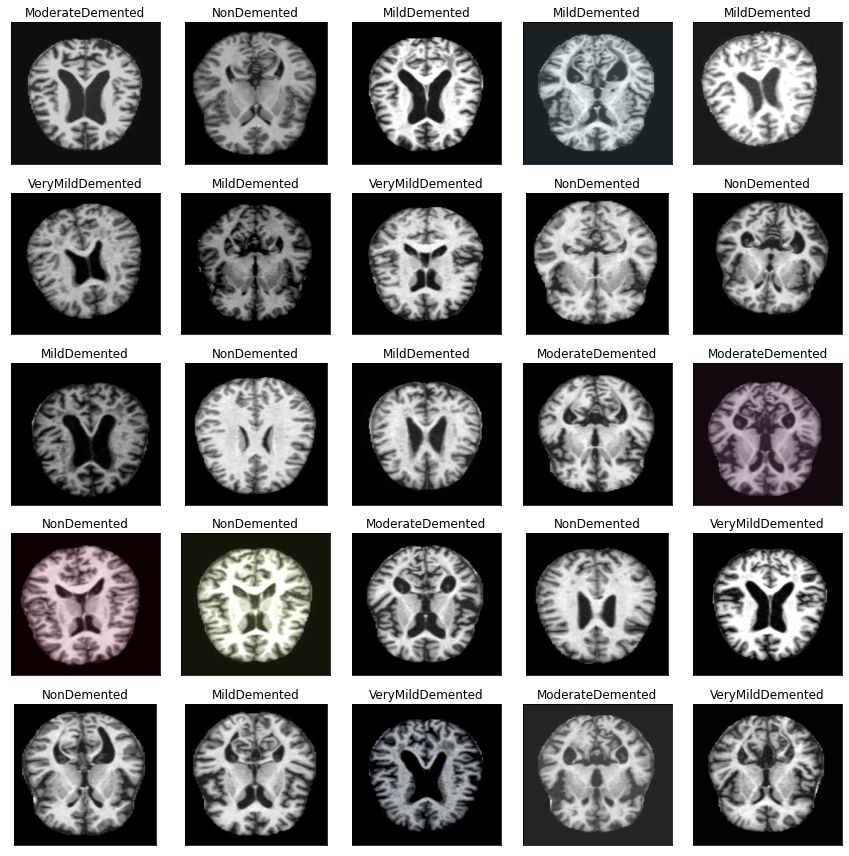

In [ ]:
# Display 25 picture of the augmented dataset with their labels
random_index = np.random.randint(0, len(train_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(train_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Augmented.pdf")

plt.show()

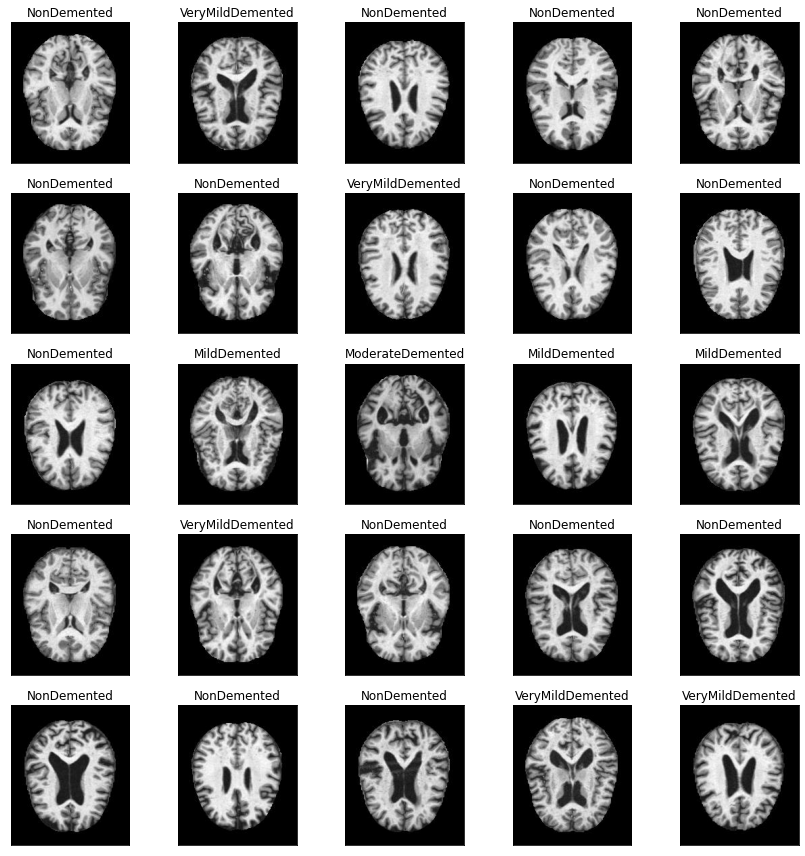

In [ ]:
# Display 25 picture of the original dataset with their labels
random_index = np.random.randint(0, len(test_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(test_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(test_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Original.pdf")
plt.show()

In [ ]:
print("Train data set label distribution:\n",train_df.Label.value_counts())

print("\nTest data set label distribution:\n", test_df.Label.value_counts())

Train data set label distribution:
 NonDemented         9600
VeryMildDemented    8960
MildDemented        8960
ModerateDemented    6464
Name: Label, dtype: int64

Test data set label distribution:
 NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: Label, dtype: int64


In [ ]:
base_dir = "/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data"
root_dir = "./"
train_dir = base_dir + "AugmentedAlzheimerDataset/"
test_dir = base_dir + "OriginalDataset/"
#work_dir = root_dir + "dataset/"

#if os.path.exists(work_dir):
#    remove_tree(work_dir)


#os.mkdir(work_dir)
#copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
#print("Working Directory Contents:", os.listdir(work_dir))

In [ ]:
#WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
test_gen_plot = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 6400 images belonging to 4 classes.


--------

In [ ]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """

    # Evaluate the results:
    #. test_metrics[0] = loss,
    #  test_metrics[1] = auc,
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))


    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)

    # create plots
    plt.subplots(figsize=(12,4))

    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()


     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [ ]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))

    y_true = np.argmax(y_true, axis=1)

    return y_true, y_pred

----

# MODELS #

## VGG19

In [ ]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
______________________________________________________________

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
77/77 [==============================] - 304s 4s/step - loss: 1.0553 - auc: 0.8051 - acc: 0.5554 - val_loss: 0.7723 - val_auc: 0.9116 - val_acc: 0.6969
Epoch 2/50
77/77 [==============================] - 82s 1s/step - loss: 0.7193 - auc: 0.9210 - acc: 0.7171 - val_loss: 0.6525 - val_auc: 0.9359 - val_acc: 0.7493
Epoch 3/50
77/77 [==============================] - 80s 1s/step - loss: 0.6289 - auc: 0.9396 - acc: 0.7572 - val_loss: 0.5902 - val_auc: 0.9471 - val_acc: 0.7716
Epoch 4/50
77/77 [==============================] - 80s 1s/step - loss: 0.5720 - auc: 0.9503 - acc: 0.7783 - val_loss: 0.5758 - val_auc: 0.9450 - val_acc: 0.7625
Epoch 5/50
77/77 [==============================] - 81s 1s/step - loss: 0.5273 - auc: 0.9586 - acc: 0.8011 - val_loss: 0.5444 - val_auc: 0.9503 - val_acc: 0.7716
Epoch 6/50
77/77 [==============================] - 81s 1s/step - loss: 0.5041 - auc: 0.9609 - acc: 0.8063 - val_loss: 0.4966 - val_auc: 0.9611 - val_acc: 0.8140
Epoch 7/50
77/77 [=========


 Model AUC 99.42%, Accuracy 93.14% on Test Data

              precision    recall  f1-score   support

        mild       0.96      0.97      0.96       896
    moderate       1.00      1.00      1.00        64
      normal       0.92      0.95      0.94      3200
   very-mild       0.93      0.89      0.91      2240

    accuracy                           0.93      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.93      0.93      0.93      6400



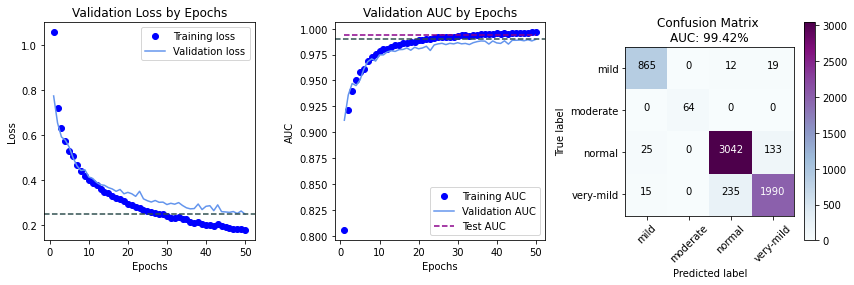

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg19")